Для любой модели из курса(кроме KNN) и данных на которых она строилась: примнить метод главных компонент к данным, и сравнить работу модели на исходных данных с работой на данных где в качестве признаков используются две главные компоненты.

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

from sklearn import model_selection
import numpy as np

In [2]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
def get_error(pred, y):
    return np.sum((pred != y).astype(int)) / len(y)

In [3]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[np.logical_not(match)] *= np.exp(alpha)
        w[match] *= np.exp(-alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

In [4]:
N = 10

models = adaboost(X_train, y_train, N)

In [5]:
def predict(X, models, n_classes = 2):
    
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 96.009


In [6]:
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на тестовой выборке: 92.308


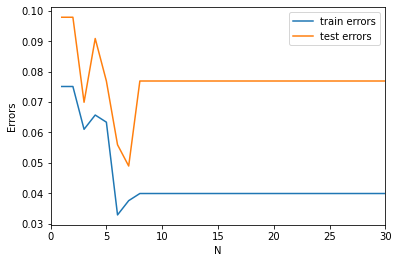

In [7]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Errors')
plt.legend(loc='upper right')

Снижение размерности данных

In [8]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [9]:
# Загрузим игрушечный датасет из sklearn
X = X_train

#print(X)

In [10]:
# Для начала отмасштабируем выборку
X_ = X.astype(float)

rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по строке
means = X_.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for i in range(cols):
    for j in range(rows):
        X_[j][i] =( X_[j][i]-means[i])/std[i]

In [11]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X_.T.dot(X_)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

#print('Собственные значения в порядке убывания:')
#for i in eig_pairs:
#    print(i[0])

In [12]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
#print(f'Доля дисперсии, описвыаемая каждой из компонент \n{var_exp}')

# а теперя оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Кумулятивная доля дисперсии по компонентам 
[ 94.75620858  96.76149981  97.76876778  98.38575344  98.8023959
  99.07275405  99.27353974  99.42377568  99.5317938   99.62775647
  99.70671268  99.7749935   99.82756659  99.87375459  99.91023091
  99.9292435   99.94206551  99.95326921  99.96306291  99.97174364
  99.97887997  99.98393504  99.98828441  99.9919784   99.99511327
  99.99775107  99.99949378  99.99983938  99.99997161 100.        ]


In [13]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(30,1), eig_pairs[1][1].reshape(30,1))) # доля дисперсии на эти 2 компоненты ~96%

#print(f'Матрица весов W:\n', W)

In [14]:
# Сформируем новую матрицу "объекты-признаки"
X_train_pca = X_.dot(W)

In [15]:
# Для начала отмасштабируем выборку
X_normed_test = X_test.astype(float)

rows, cols = X_normed_test.shape

# центрирование - вычитание из каждого значения среднего по строке
means = X_normed_test.mean(0)
for i in range(rows):
    for j in range(cols):
        X_normed_test[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_normed_test, axis=0)
for i in range(cols):
    for j in range(rows):
        X_normed_test[j][i] = (X_normed_test[j][i] - means[i]) / std[i]

In [16]:
# Сформируем новую матрицу "объекты-признаки" для тестовой подвыборки
X_test_pca = X_normed_test.dot(W)

In [17]:
N = 10

models = adaboost(X_train_pca, y_train, N)

In [18]:
print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train_pca, models), y_train)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 94.366


In [19]:
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test_pca, models), y_test)) * 100:.3f}')

Точность алгоритма на тестовой выборке: 91.608


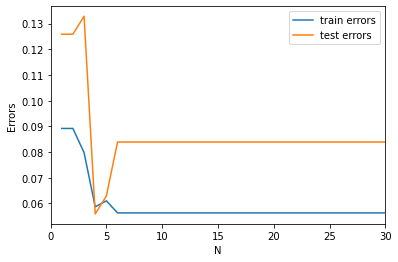

In [20]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train_pca, y_train, n)
    train_errors.append(get_error(predict(X_train_pca, mods), y_train))
    test_errors.append(get_error(predict(X_test_pca, mods), y_test))
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Errors')
plt.legend(loc='upper right')

In [21]:
# Сформируем вектор весов из собственных векторов, соответствующих первым 4 главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(30,1), eig_pairs[1][1].reshape(30,1), eig_pairs[2][1].reshape(30,1), 
               eig_pairs[3][1].reshape(30,1))) # доля дисперсии на эти 4 компонент ~98%

#print(f'Матрица весов W:\n', W)

In [22]:
# Сформируем новую матрицу "объекты-признаки"
X_train_pca_4 = X_.dot(W)

In [23]:
# Для начала отмасштабируем выборку
X_normed_test = X_test.astype(float)

rows, cols = X_normed_test.shape

# центрирование - вычитание из каждого значения среднего по строке
means = X_normed_test.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_normed_test, axis=0)
for i in range(cols):
    for j in range(rows):
        X_normed_test[j][i] =( X_normed_test[j][i]-means[i])/std[i]

In [24]:
# Сформируем новую матрицу "объекты-признаки" для тестовой подвыборки
X_test_pca_4 = X_normed_test.dot(W)

In [25]:
N = 10

models = adaboost(X_train_pca_4, y_train, N)

In [26]:
print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train_pca_4, models), y_train)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 94.366


In [27]:
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test_pca_4, models), y_test)) * 100:.3f}')

Точность алгоритма на тестовой выборке: 79.720


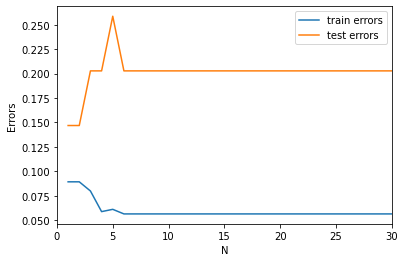

In [28]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train_pca_4, y_train, n)
    train_errors.append(get_error(predict(X_train_pca_4, mods), y_train))
    test_errors.append(get_error(predict(X_test_pca_4, mods), y_test))
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Errors')
plt.legend(loc='upper right')

In [29]:
class logistic_regression:
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations=1000
        self.eta=eta
    def _log_grad(self, X, target):
        m = X.shape[0]
        y=(2*target-1)
        score=np.dot(X, self.w.T).flatten()+self.w0
        Z=-y/(m*(1+np.exp(y*score)))
        grad=Z[np.newaxis, :].dot(X)
        return grad/m, np.sum(Z)/m
    def _optimize(self, X, target):
        for i in range(self.n_iterations):        
            grad_w, grad_w0 = self._log_grad(X, target)
            self.w = self.w-self.eta * grad_w
            self.w0 = self.w0 - self.eta * grad_w0
    def fit(self, X, target):
        self.w = np.zeros((1, X.shape[1]))
        self.w0=0
        self._optimize(X, target)
    def predict_proba(self, X):  
        '''
        Рассчёт вероятности
        '''
        score=X.dot(self.w.T).flatten()+self.w0
        return 1/(1+np.exp(-score))
    def predict(self, X, thr=0.5):
        proba=self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=bool) 
        y_predicted[proba>thr]=1
        y_predicted[proba<=thr]=0
        return y_predicted

Логистическая регрессия на датасете уменьшенной размерности

In [30]:
mod=logistic_regression()
mod.fit(X_train_pca, y_train)
y_predicted_test = mod.predict(X_test_pca)
y_predicted_train = mod.predict(X_train_pca)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)


print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Точность на обучающей выборке: 69.484
Точность на тестовой выборке: 66.434


Логистическая регрессия на исходном датасете

In [31]:
mod=logistic_regression()
mod.fit(X_train, y_train)
y_predicted_test = mod.predict(X_test)
y_predicted_train = mod.predict(X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)


print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Точность на обучающей выборке: 92.488
Точность на тестовой выборке: 90.909


Снижение размерности лучше работает с алгоритмом адаптивного бустинга с решающими деревьями, чем с логистической регрессией.
Так же увеличение количества используемых главных компонент не привело к улучшению модели, тк 1я компонента описывает 95% 
дисперсии, 2я - 2%, остальные <=1% дисперсии.